In [3]:
import sys
sys.path.append('..')
import pandas as pd
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
matplotlib.rcParams['text.usetex']=True

In [7]:
# Get the data
df = pd.read_pickle('../data/database_with_queries.pd')

In [8]:
def guess_most_common(summary,queries,q_type):

    # Simplify the ents_mentioned info by representing each entity with their ID number
    def ent_to_id(entString):
        return int(entString[3:])
    def set_to_ids(ent_set):
        return [ent_to_id(x) for x in list(ent_set)]
    def mentions_to_id(ent_mentions):
        return [set_to_ids(x) for x in ent_mentions]
    
    if q_type == 'm': # multiple
        # For each sentence, get a list of the unique entities mentioned
        ents_mentioned = [set(re.findall('ent\d\d\d',x[0])) for x in queries]
        # List of entities (by ID) mentioned in each sentence of the char descriptions
        ids_mentioned = mentions_to_id( ents_mentioned )
        
    # Count total mentions of each known entity in the summary
    largest_ent = ent_to_id(max(set( re.findall('ent\d\d\d',summary) )))
    tot_mentions = []
    for e in range(largest_ent+1):
        this_ent = 'ent%03d' % e
        tot_mentions = tot_mentions + [len( re.findall( this_ent, summary) )]
    
    # Go through each query and guess the most common entity not in the query
    if q_type == 's':
        # This super easy, always guess the most mentioned entity
        most_mentions = max(tot_mentions)
        most_mentioned = [x for x in range(largest_ent+1) if tot_mentions[x]==most_mentions]
        # In case multiple entities are each the most common
        nmm = len(most_mentioned)
        # Go through each query and see how often this works
        n_correct = 0.0
        for x in queries:
            if any([x[1]==g for g in most_mentioned]):
                n_correct += 1.0
        frac_correct = n_correct / len(queries)
        adj_frac_correct = frac_correct / nmm
        return len(queries), n_correct/nmm
    elif q_type == 'm':
        # Slightly more difficult but still easy
        # Make a default list of entity choices and their mentions
        all_ents = range(largest_ent+1)
        all_tots = list( tot_mentions )
        # Step through each query
        adj_n_correct = 0.0
        for i,q in enumerate(queries):
            # Set up new copies of our choices
            these_ents = list( all_ents )
            these_tots = list( all_tots )
            # Remove entities in the query from the options
            for idx in range(len(ids_mentioned[i])):
                del these_ents[idx]
                del these_tots[idx]
            # Choose the most mentioned from what remains
            most_mentions = max(these_tots)
            most_mentioned = [x for x in these_ents if tot_mentions[x]==most_mentions]
            nmm = len(most_mentioned)
            # If any of the most mentioned are correct, increase adj_n_correct
            if any([q[1]==g for g in most_mentioned]):
                adj_n_correct += 1.0 / nmm
        adj_frac_correct = adj_n_correct / len(queries)
        return len(queries), adj_n_correct

In [4]:
bl_perf_solo = np.zeros((df.shape[0],4))
bl_perf_mult = np.zeros((df.shape[0],4))

for i in range(df.shape[0]):
    book = df.iloc[i]
    S2 = book['anon_sum_ii']
    S4 = book['anon_sum_iiii']
    if S2:
        qS = book['solo_queries_ii']
        qS = zip(qS[0],qS[1])
        qM = book['mult_queries_ii']
        qM = zip(qM[0],qM[1])
        if qS: bl_perf_solo[i,0], bl_perf_solo[i,1] = guess_most_common(S2,qS,'s')
        else:
            bl_perf_solo[i,0] = np.nan
            bl_perf_solo[i,1] = np.nan
        if qM: bl_perf_mult[i,0], bl_perf_mult[i,1] = guess_most_common(S2,qM,'m')
        else:
            bl_perf_mult[i,0] = np.nan
            bl_perf_mult[i,1] = np.nan
    else:
        bl_perf_solo[i,0] = np.nan
        bl_perf_solo[i,1] = np.nan
        bl_perf_mult[i,0] = np.nan
        bl_perf_mult[i,1] = np.nan
    if S4:
        qS = book['solo_queries_iiii']
        qS = zip(qS[0],qS[1])
        qM = book['mult_queries_iiii']
        qM = zip(qM[0],qM[1])
        if qS: bl_perf_solo[i,2], bl_perf_solo[i,3] = guess_most_common(S4,qS,'s')
        else:
            bl_perf_solo[i,2] = np.nan
            bl_perf_solo[i,3] = np.nan
        if qM: bl_perf_mult[i,2], bl_perf_mult[i,3] = guess_most_common(S4,qM,'m')
        else:
            bl_perf_mult[i,2] = np.nan
            bl_perf_mult[i,3] = np.nan
    else:
        bl_perf_solo[i,2] = np.nan
        bl_perf_solo[i,3] = np.nan
        bl_perf_mult[i,2] = np.nan
        bl_perf_mult[i,3] = np.nan

In [5]:
bl_solo = np.concatenate((bl_perf_solo[:,0:2],bl_perf_solo[:,2:4]))
bl_mult = np.concatenate((bl_perf_mult[:,0:2],bl_perf_mult[:,2:4]))

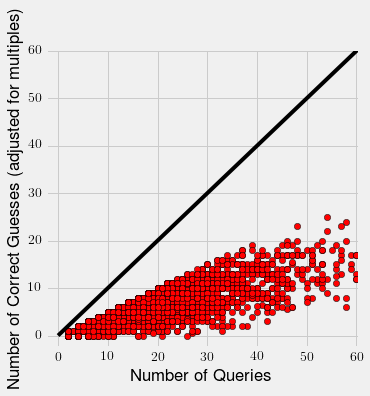

In [12]:
fig = plt.figure(figsize=(5,5))
ax = plt.axes()
ax.plot(bl_mult[:,0],bl_mult[:,1],'ro',[0,70],[0,70],'k-')
ax.set_xlabel('Number of Queries')
ax.set_ylabel('Number of Correct Guesses (adjusted for multiples)');
ax.set_xlim([-2.5,60.5]);
ax.set_ylim([-2.5,60.5]);

In [9]:
print np.nanmean( bl_solo[:,1]/bl_solo[:,0])
print np.nanmean( bl_mult[:,1]/bl_mult[:,0])

0.473242772527
0.351853799518


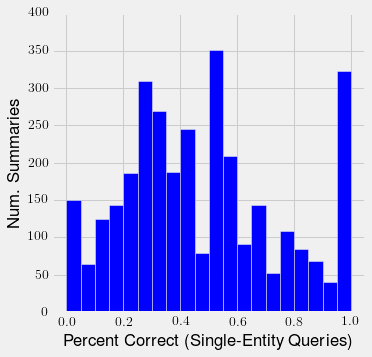

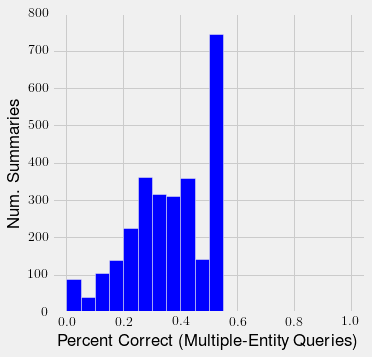

In [10]:
x = np.arange(0,1.05,.05)
b = x[0:-1]
Hs = np.histogram(bl_solo[:,1]/bl_solo[:,0],x)
Hm = np.histogram(bl_mult[:,1]/bl_mult[:,0],x)

fig = plt.figure(figsize=(5,5))
ax = plt.axes()
ax.bar(b,Hs[0],.05)
ax.set_xlabel('Percent Correct (Single-Entity Queries)')
ax.set_ylabel('Num. Summaries');
ax.set_xlim([-.05,1.05]);
fig.savefig('single_ent_baseline.png', transparent=True, dpi=200, bbox_inches='tight')

fig = plt.figure(figsize=(5,5))
ax = plt.axes()
ax.bar(b,Hm[0],.05)
ax.set_xlabel('Percent Correct (Multiple-Entity Queries)')
ax.set_ylabel('Num. Summaries');
ax.set_xlim([-.05,1.05]);
fig.savefig('multiple_ent_baseline.png', transparent=True, dpi=200, bbox_inches='tight')

In [14]:
QL = [s+m for s, m in zip(SQL, MQL)]

In [21]:
max(QL)

102

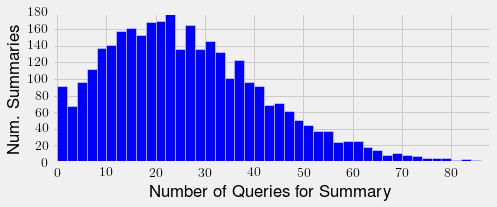

In [24]:
x = np.arange(0,90,2)
b = x[0:-1]
H = np.histogram(QL,x)

fig = plt.figure(figsize=(7,2.5));
ax = plt.axes();
ax.bar(b,H[0],2);
ax.set_xlabel('Number of Queries for Summary');
ax.set_ylabel('Num. Summaries');
ax.set_xlim([-1,max(x)]);
fig.savefig('../data/query_num_histogram.png', transparent=True, dpi=200, bbox_inches='tight')

In [9]:
SQL2 = [len(df['solo_queries_ii'][x][0]) for x in df.index if df['solo_queries_ii'][x]]
SQL4 = [len(df['solo_queries_iiii'][x][0]) for x in df.index if df['solo_queries_iiii'][x]]
SQL = SQL2 + SQL4

MQL2 = [len(df['mult_queries_ii'][x][0]) for x in df.index if df['mult_queries_ii'][x]]
MQL4 = [len(df['mult_queries_iiii'][x][0]) for x in df.index if df['mult_queries_iiii'][x]]
MQL = MQL2 + MQL4

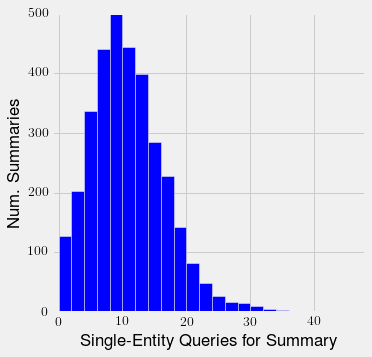

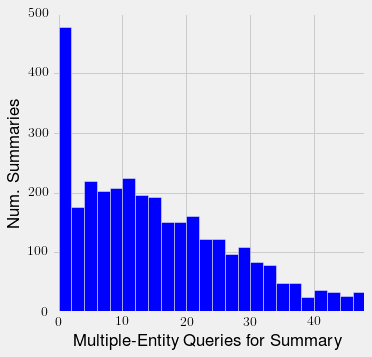

In [14]:
x = np.arange(0,50,2)
b = x[0:-1]
Hs = np.histogram(SQL,x)
Hm = np.histogram(MQL,x)

fig = plt.figure(figsize=(5,5))
ax = plt.axes()
ax.bar(b,Hs[0],2)
ax.set_xlabel('Single-Entity Queries for Summary')
ax.set_ylabel('Num. Summaries');
ax.set_xlim([-1,max(x)]);
fig.savefig('single_ent_freq.png', transparent=True, dpi=200, bbox_inches='tight')

fig = plt.figure(figsize=(5,5))
ax = plt.axes()
ax.bar(b,Hm[0],2)
ax.set_xlabel('Multiple-Entity Queries for Summary')
ax.set_ylabel('Num. Summaries');
ax.set_xlim([-1,max(x)]);
fig.savefig('multiple_ent_freq.png', transparent=True, dpi=200, bbox_inches='tight')

In [212]:
tq2 = 0
for i in df.index:
    if df['anon_sum_ii'][i]: tq2 += 1
tq2

1859

In [213]:
tq4 = 0
for i in df.index:
    if df['anon_sum_iiii'][i]: tq4 += 1
tq4

1455

In [214]:
tqB = 0
for i in df.index:
    if df['anon_sum_ii'][i] and df['anon_sum_iiii'][i]: tqB += 1
tqB

469

In [216]:
tq2 + tq4

3314

In [220]:
np.nansum(bl_mult,axis=0)

array([ 36903.        ,  11851.58333333])

In [221]:
11851.5833/36903

0.32115500907785277